In [1]:
import numpy as np
import scipy as sp
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import torch
import fb_utils as fb
import time

In [10]:
def tight(w, ver='S'):
    if ver == 'poly':
        M, N = w.shape
        w_freqz = np.fft.fft(w,axis=1).T
        w_tight = np.zeros((M, N), dtype=np.complex64)
        for k in range(N):
            H = w_freqz[k, :]
            U = H / np.linalg.norm(H)
            w_tight[:,k] = np.conj(U)
        w_tight = np.fft.ifft(w_tight.T, axis=0).T
    elif ver == 'S':
        W = np.concatenate([sp.linalg.circulant(w[k, :]) for k in range(w.shape[0])])
        S = np.matmul(W.T,W)
        S_sq = np.linalg.inv(sp.linalg.sqrtm(S))
        w_tight = np.matmul(S_sq,w.T).T
    else:
        raise NotImplementedError
    return w_tight

In [12]:
def fir_tightener3000(w, supp, eps=1.1, print_kappa=False):
    A,B = fb.frame_bounds_lp(w)
    w_tight = w.copy()
    while B/A > eps:
        w_tight = tight(w_tight, ver='S')
        w_tight[:,supp:] = 0
        w_tight = np.real(w_tight)
        A,B = fb.frame_bounds_lp(w_tight)
        if print_kappa:
            print('kappa:', B/A, 'error:', np.linalg.norm(w-w_tight))
    return w_tight

In [54]:
N = 1024
J = 10
T = N//2
w = fb.random_filterbank(N, J, T, tight=False, support_only=False, to_torch=False)

w_tight = fir_tightener3000(w, T, eps=1.1, print_kappa=True)


kappa: 2.0725901569395138 error: 0.12719482412827351
kappa: 1.6575226421576876 error: 0.15915794330419056
kappa: 1.4906677365253351 error: 0.1744590487069184
kappa: 1.394659848087046 error: 0.18363445576152354
kappa: 1.3295524198672468 error: 0.18982744552233383
kappa: 1.2892128354179526 error: 0.19433218466148752
kappa: 1.2586523915337695 error: 0.19778458936306165
kappa: 1.2336994850187482 error: 0.2005341179343252
kappa: 1.2128262542861796 error: 0.20278844686628397
kappa: 1.1950581122301167 error: 0.20467857398648406
kappa: 1.1797276019922927 error: 0.20629124098058935
kappa: 1.1663550836652727 error: 0.20768630820449213
kappa: 1.1545839848609598 error: 0.20890659618073593
kappa: 1.1441423858069621 error: 0.2099837127491265
kappa: 1.1348186646011695 error: 0.2109416352578788
kappa: 1.1264452911073966 error: 0.21179898717641416
kappa: 1.1188876534109378 error: 0.21257052967447
kappa: 1.1120361457178076 error: 0.21326816692859435
kappa: 1.1058004479961663 error: 0.21390164186112967
k

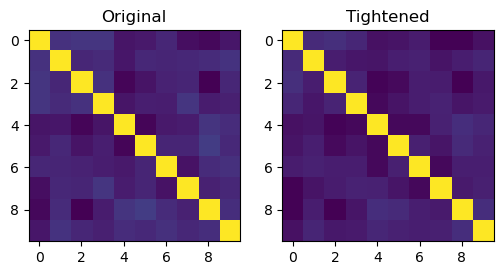

In [57]:
# compute cross-correlation matrix of w_tight
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(np.corrcoef([w[k,1:] for k in range(w.shape[0])] ))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(np.corrcoef([w_tight[k,1:] for k in range(w_tight.shape[0])] ))
plt.title('Tightened')
plt.show()

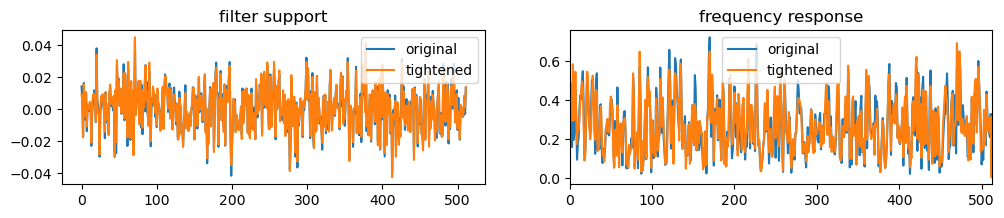

In [56]:
# plot frequency response of w_tight
# 2 plots next to eachother: one for w, one for w_tight

plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(w[0,:T].T, label='original')
plt.plot(w_tight[0,:T].T, label='tightened')
plt.title('filter support')
plt.legend()
plt.subplot(1,2,2)
w_freqz = np.abs(np.fft.fft(w,axis=1).T)
plt.plot(w_freqz[:,0], label='original')
w_tight_freqz = np.abs(np.fft.fft(w_tight,axis=1).T)
plt.plot(w_tight_freqz[:,0], label='tightened')
plt.xlim([0,N//2+1])
plt.title('frequency response')
plt.legend()
plt.show()